In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb

Read data

In [2]:
df = pd.read_csv('data/sales_train_v2.csv')
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


Print dtypes and memory consumption

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
date              object
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Downcast dtypes to save memory

In [4]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

df = downcast_dtypes(df)
#df.info()

Add aggregations

In [ ]:
'''grid = []
for date_block in df['date_block_num'].unique():
    
    # cartesian product of shops x items in each month
    cur_shops = df[df['date_block_num'] == date_block]['shop_id'].unique()
    cur_items = df[df['date_block_num'] == date_block]['item_id'].unique()
    grid.append(np.array(list(itertools.product(*[cur_shops, cur_items, [date_block]])),dtype='int32'))'''

In [ ]:
#grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [5]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

In [6]:
df['item_cnt_day'] = df['item_cnt_day'].clip(0,20)
gb_cnt = df.groupby(index_cols)['item_cnt_day'].agg(['sum']).reset_index().rename(columns = {'sum': 'item_cnt_month'})
gb_cnt['item_cnt_month'] = gb_cnt['item_cnt_month'].clip(0,20).astype(np.int)

In [7]:
gb_cnt.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,0,30,1,20
1,0,31,1,11
2,0,32,0,6
3,0,32,1,10
4,0,33,0,3


In [8]:
#join aggregated data to the grid

df = pd.merge(df, gb_cnt, how='left', on=index_cols).fillna(0)
df['item_cnt_month'] = df['item_cnt_month'].astype(int)
df = downcast_dtypes(df)

In [9]:
items = pd.read_csv('data/items.csv')

In [10]:
df = pd.merge(df, items[['item_id', 'item_category_id']], on = 'item_id')
#df.to_csv('train_with_grid.csv')

df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id
0,02.01.2013,0,59,22154,999.0,1.0,1,37
1,23.01.2013,0,24,22154,999.0,1.0,1,37
2,20.01.2013,0,27,22154,999.0,1.0,1,37
3,02.01.2013,0,25,22154,999.0,1.0,5,37
4,03.01.2013,0,25,22154,999.0,1.0,5,37


In [11]:
df.to_feather('df_with_item_cnt_month')

Load data

In [12]:
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')

df_test = pd.read_csv('data/test.csv', delimiter="," ,skiprows=1, usecols = (1,2), dtype=int)
df_test = pd.DataFrame(df_test, columns = ['shop_id', 'item_id'])

print('Merging with other datasets...')
# Get item category id into test_df
df_test = df_test.merge(items[['item_id', 'item_category_id']], on = 'item_id', how = 'left')
df_test['date_block_num'] = 34
# Make testset contains same column as trainset so we can concatenate them row-wise
df_test['item_cnt_month'] = -1

df_train_test = pd.concat([df, df_test], axis = 0) 

Merging with other datasets...


/home/sfczekalski/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [13]:
item_cat = pd.read_csv('data/item_categories.csv')

# Fix category
categories_list = list(item_cat.item_category_name)
for ind in range(0,1):
    categories_list[ind] = 'PC Headsets / Headphones'
for ind in range(1,8):
    categories_list[ind] = 'Access'
categories_list[8] = 'Tickets (figure)'
categories_list[9] = 'Delivery of goods'
for ind in range(10,18):
    categories_list[ind] = 'Consoles'
for ind in range(18,25):
    categories_list[ind] = 'Consoles Games'
categories_list[25] = 'Accessories for games'
for ind in range(26,28):
    categories_list[ind] = 'phone games'
for ind in range(28,32):
    categories_list[ind] = 'CD games'
for ind in range(32,37):
    categories_list[ind] = 'Card'
for ind in range(37,43):
    categories_list[ind] = 'Movie'
for ind in range(43,55):
    categories_list[ind] = 'Books'
for ind in range(55,61):
    categories_list[ind] = 'Music'
for ind in range(61,73):
    categories_list[ind] = 'Gifts'
for ind in range(73,79):
    categories_list[ind] = 'Soft'
for ind in range(79,81):
    categories_list[ind] = 'Office'
for ind in range(81,83):
    categories_list[ind] = 'Clean'
categories_list[83] = 'Elements of a food'

In [14]:
df_train_test.head()

,date,date_block_num,item_category_id,item_cnt_day,item_cnt_month,item_id,item_price,shop_id
0,02.01.2013,0,37.0,1.0,1,22154.0,999.0,59.0
1,23.01.2013,0,37.0,1.0,1,22154.0,999.0,24.0
2,20.01.2013,0,37.0,1.0,1,22154.0,999.0,27.0
3,02.01.2013,0,37.0,1.0,5,22154.0,999.0,25.0
4,03.01.2013,0,37.0,1.0,5,22154.0,999.0,25.0


In [15]:
item_cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [17]:
label_encoder = LabelEncoder()
#item_cat['item_category_name_int'] = label_encoder.fit_transform(item_cat['item_category_name'])

item_cat['item_category_id_fix'] = label_encoder.fit_transform(categories_list)
item_cat['item_category_name_fix'] = categories_list
df_train_test = df_train_test.merge(item_cat[['item_category_id', 'item_category_id_fix']], on = 'item_category_id', how = 'left')
_ = df_train_test.drop(['item_category_id'],axis=1, inplace=True)
df_train_test.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)

_ = item_cat.drop(['item_category_id'],axis=1, inplace=True)
_ = item_cat.drop(['item_category_name'],axis=1, inplace=True)

item_cat.rename(columns = {'item_category_id_fix':'item_category_id'}, inplace = True)
item_cat.rename(columns = {'item_category_name_fix':'item_category_name'}, inplace = True)
item_cat = item_cat.drop_duplicates()
item_cat.index = np.arange(0, len(item_cat))


item_cat.head()

,item_category_id,item_category_name
0,14,PC Headsets / Headphones
1,0,Access
2,16,Tickets (figure)
3,8,Delivery of goods
4,6,Consoles


In [19]:
df_train_test = df_train_test.merge(item_cat, on = 'item_category_id', how = 'left')
df_train_test.head()

,date,date_block_num,item_cnt_day,item_cnt_month,item_id,item_price,shop_id,item_category_id,item_category_name
0,02.01.2013,0,1.0,1,22154.0,999.0,59.0,11.0,Movie
1,23.01.2013,0,1.0,1,22154.0,999.0,24.0,11.0,Movie
2,20.01.2013,0,1.0,1,22154.0,999.0,27.0,11.0,Movie
3,02.01.2013,0,1.0,5,22154.0,999.0,25.0,11.0,Movie
4,03.01.2013,0,1.0,5,22154.0,999.0,25.0,11.0,Movie


In [20]:
df_train_test['item_category_name'].isna().any()

True

In [23]:
df_train_test['item_category_id'].isna().any()

True

In [22]:
df_train_test['item_category_name'].fillna(value='Other', inplace=True)

In [24]:
df_train_test['item_category_id'].fillna(value=-1, inplace=True)

In [ ]:
df_train_test['item_category_name'].value_counts()

In [34]:
df['item_category_id'] = df['item_category_id'].astype(np.int16)
df['shop_id'] = df['shop_id'].astype(np.int16)
df['item_id'] = df['item_id'].astype(np.int16)
df['item_cnt_day'] = df['item_cnt_day'].astype(np.int16)
df['item_id'] = df['item_id'].astype(np.int16)
df = downcast_dtypes(df)

In [35]:
df_train_test.to_feather('df_preprocessed')

In [38]:
df_preprocessed = pd.read_feather('df_preprocessed')
df_preprocessed.head()

,date,date_block_num,item_cnt_day,item_cnt_month,item_id,item_price,shop_id,item_category_id,item_category_name
0,02.01.2013,0,1.0,1,22154.0,999.0,59.0,11.0,Movie
1,23.01.2013,0,1.0,1,22154.0,999.0,24.0,11.0,Movie
2,20.01.2013,0,1.0,1,22154.0,999.0,27.0,11.0,Movie
3,02.01.2013,0,1.0,5,22154.0,999.0,25.0,11.0,Movie
4,03.01.2013,0,1.0,5,22154.0,999.0,25.0,11.0,Movie


In [40]:
df['item_id'].fillna(value=-1, inplace=True)
df['item_id'] = df['item_id'].astype(np.int)
df['shop_id'].fillna(value=-1, inplace=True)
df['shop_id'] = df['shop_id'].astype(np.int)
df = downcast_dtypes(df)
df = df[df['date_block_num'] >= 12]
df_test = df[df['date_block_num'] == 34]
df_val = df[df['date_block_num'] == 33]
df_train = df[df['date_block_num'] <= 32]

Lag features: number of items sold in previous month for shop, item and category

In [51]:
lag_columns = ['shop_id', 'item_id', 'item_category_id']
lag = 12

for lag_column in lag_columns:

    df_lag = df.groupby([lag_column, 'date_block_num'])['item_cnt_month'].sum()
    df_lag.head()
    df['merge_month'] = df['date_block_num'] - lag
    df = pd.merge(df, df_lag, how='left', left_on=[lag_column, 'merge_month'], right_on=[lag_column, 'date_block_num']).fillna(0)
    df.rename(columns={'item_cnt_month_y': str(lag_column) + '_lag_' + str(lag)}, inplace=True)
    df.rename(columns={'item_cnt_month_x': 'item_cnt_month'}, inplace=True)
    df.drop(columns='merge_month', inplace=True)


df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id,shop_id_lag_1,item_id_lag_1,item_category_id_lag_1,shop_id_lag_2,item_id_lag_2,item_category_id_lag_2,shop_id_lag_3,item_id_lag_3,item_category_id_lag_3,shop_id_lag_12,item_id_lag_12,item_category_id_lag_12
0,2015-07-19,30,6,22154,299.0,1,1,37,4913.0,0.0,10190.0,4430.0,0.0,7617.0,5909.0,0.0,15413.0,8195.0,0.0,11055.0
1,2015-07-25,30,42,22154,299.0,1,2,37,12902.0,0.0,10190.0,12805.0,0.0,7617.0,15513.0,0.0,15413.0,12485.0,0.0,11055.0
2,2015-07-17,30,42,22154,299.0,1,2,37,12902.0,0.0,10190.0,12805.0,0.0,7617.0,15513.0,0.0,15413.0,12485.0,0.0,11055.0
3,2015-07-20,30,57,22154,299.0,1,1,37,8593.0,0.0,10190.0,7705.0,0.0,7617.0,10473.0,0.0,15413.0,14663.0,0.0,11055.0
4,2015-07-18,30,35,22154,299.0,1,1,37,3821.0,0.0,10190.0,4205.0,0.0,7617.0,4995.0,0.0,15413.0,5826.0,0.0,11055.0


In [42]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [52]:
df.to_feather('df_preprocessed_lag_1_2_3_12')

Mean item price from previous month

In [56]:
lag = 1

df_lag = df.groupby(['item_id', 'date_block_num'])['item_price'].mean()
df_lag.head()
df['merge_month'] = df['date_block_num'] - lag
df = pd.merge(df, df_lag, how='left', left_on=['item_id', 'merge_month'], right_on=['item_id', 'date_block_num']).fillna(0)
df.rename(columns={'item_price_y': 'previous_month_price'}, inplace=True)
df.rename(columns={'item_price_x': 'item_price'}, inplace=True)
df.drop(columns='merge_month', inplace=True)

In [60]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id,shop_id_lag_1,item_id_lag_1,...,shop_id_lag_2,item_id_lag_2,item_category_id_lag_2,shop_id_lag_3,item_id_lag_3,item_category_id_lag_3,shop_id_lag_12,item_id_lag_12,item_category_id_lag_12,previous_month_price
0,2015-07-19,30,6,22154,299.0,1,1,37,4913.0,0.0,...,4430.0,0.0,7617.0,5909.0,0.0,15413.0,8195.0,0.0,11055.0,0.0
1,2015-07-25,30,42,22154,299.0,1,2,37,12902.0,0.0,...,12805.0,0.0,7617.0,15513.0,0.0,15413.0,12485.0,0.0,11055.0,0.0
2,2015-07-17,30,42,22154,299.0,1,2,37,12902.0,0.0,...,12805.0,0.0,7617.0,15513.0,0.0,15413.0,12485.0,0.0,11055.0,0.0
3,2015-07-20,30,57,22154,299.0,1,1,37,8593.0,0.0,...,7705.0,0.0,7617.0,10473.0,0.0,15413.0,14663.0,0.0,11055.0,0.0
4,2015-07-18,30,35,22154,299.0,1,1,37,3821.0,0.0,...,4205.0,0.0,7617.0,4995.0,0.0,15413.0,5826.0,0.0,11055.0,0.0


In [61]:
df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_cnt_month', 'item_category_id', 'shop_id_lag_1',
       'item_id_lag_1', 'item_category_id_lag_1', 'shop_id_lag_2',
       'item_id_lag_2', 'item_category_id_lag_2', 'shop_id_lag_3',
       'item_id_lag_3', 'item_category_id_lag_3', 'shop_id_lag_12',
       'item_id_lag_12', 'item_category_id_lag_12', 'previous_month_price'],
      dtype='object')

In [62]:
df.to_feather('df_preprocessed_lag_1_2_3_12_prevprice')

In [70]:
lag = 12

df_lag = df.groupby(['item_id', 'shop_id', 'date_block_num'])['item_cnt_month'].sum()
df['merge_month'] = df['date_block_num'] - lag
df = pd.merge(df, df_lag, how='left', left_on=['item_id', 'shop_id', 'merge_month'], right_on=['item_id', 'shop_id', 'date_block_num']).fillna(0)
df.rename(columns={'item_cnt_month_y': 'item_shop_lag_' + str(lag)}, inplace=True)
df.rename(columns={'item_cnt_month_x': 'item_cnt_month'}, inplace=True)
df.drop(columns='merge_month', inplace=True)

In [71]:
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,item_category_id,shop_id_lag_1,item_id_lag_1,...,item_id_lag_3,item_category_id_lag_3,shop_id_lag_12,item_id_lag_12,item_category_id_lag_12,previous_month_price,item_shop_lag_1,item_shop_lag_2,item_shop_lag_3,item_shop_lag_12
0,2015-07-19,30,6,22154,299.0,1,1,37,4913.0,0.0,...,0.0,15413.0,8195.0,0.0,11055.0,0.0,0.0,0.0,0.0,0.0
1,2015-07-25,30,42,22154,299.0,1,2,37,12902.0,0.0,...,0.0,15413.0,12485.0,0.0,11055.0,0.0,0.0,0.0,0.0,0.0
2,2015-07-17,30,42,22154,299.0,1,2,37,12902.0,0.0,...,0.0,15413.0,12485.0,0.0,11055.0,0.0,0.0,0.0,0.0,0.0
3,2015-07-20,30,57,22154,299.0,1,1,37,8593.0,0.0,...,0.0,15413.0,14663.0,0.0,11055.0,0.0,0.0,0.0,0.0,0.0
4,2015-07-18,30,35,22154,299.0,1,1,37,3821.0,0.0,...,0.0,15413.0,5826.0,0.0,11055.0,0.0,0.0,0.0,0.0,0.0


In [72]:
df.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_cnt_month', 'item_category_id', 'shop_id_lag_1',
       'item_id_lag_1', 'item_category_id_lag_1', 'shop_id_lag_2',
       'item_id_lag_2', 'item_category_id_lag_2', 'shop_id_lag_3',
       'item_id_lag_3', 'item_category_id_lag_3', 'shop_id_lag_12',
       'item_id_lag_12', 'item_category_id_lag_12', 'previous_month_price',
       'item_shop_lag_1', 'item_shop_lag_2', 'item_shop_lag_3',
       'item_shop_lag_12'],
      dtype='object')

In [74]:
df.to_feather('df_preprocessed_lags_prevprice')

In [97]:
df = pd.read_feather('df_preprocessed_lags_prevprice')

In [98]:
df = downcast_dtypes(df)

features = ['date_block_num', 'shop_id', 'item_id', 'item_price',
            'item_cnt_day', 'item_category_id', 'shop_id_lag_1',
            'item_id_lag_1', 'item_category_id_lag_1', 'shop_id_lag_2',
            'item_id_lag_2', 'item_category_id_lag_2', 'shop_id_lag_3',
            'item_id_lag_3', 'item_category_id_lag_3', 'shop_id_lag_12',
            'item_id_lag_12', 'item_category_id_lag_12', 'previous_month_price',
            'item_shop_lag_1', 'item_shop_lag_2', 'item_shop_lag_3', 'item_shop_lag_12']

In [99]:
df = df[df['date_block_num'] > 12]
y_train, X_train = df[df['date_block_num'] <= 32].pop('item_cnt_month'), df[df['date_block_num'] <= 32][features]
y_val, X_val = df[df['date_block_num'] == 33].pop('item_cnt_month'), df[df['date_block_num'] == 33][features]

In [103]:
X_train = X_train[features]
X_val = X_val[features]

In [104]:
model = xgb.XGBRegressor(max_depth = 10, min_child_weight=0.5, subsample = 1, eta = 0.3, num_round = 1000, seed = 1)
model.fit(X_train.values, y_train.values, eval_metric='rmse')
preds = model.predict(X_val.values)
df_preds = pd.DataFrame(preds)
clipped_preds = df_preds.clip(0, 20).values
np.sqrt(mean_squared_error(y_val, clipped_preds))

[22:30:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


2.8233185

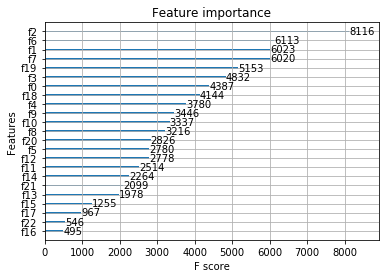

In [109]:
xgb.plot_importance(model)

In [117]:
model.feature_importances_.shape

(23,)

In [118]:
len(features)

23

In [130]:
pd.DataFrame(model.feature_importances_, columns=['importance'], index=features).sort_values(by='importance', ascending=False)

,importance
item_shop_lag_1,0.399706
item_cnt_day,0.177769
item_category_id,0.058689
previous_month_price,0.039205
item_id_lag_2,0.037869
item_category_id_lag_2,0.032596
item_price,0.024795
item_category_id_lag_1,0.022114
item_id_lag_1,0.020698
item_category_id_lag_3,0.020501
